# LL Surfaces

---

Aditya Marathe

**Aims**:

- Understand how PyOscCalc works...
    - *My understanding*: It simulates matter effects on oscillation prob.
- Calculate LL for our data...

Useful equations for an oscillation fit:

$$
    \text{ln}\mathscr{L} = - \sum_{i=1}^N \left( \text{P}_i(\text{Osc. Params.}) - \text{O}_i + \text{O}_i \times \text{ln} \frac{\text{O}_i}{\text{P}_i(\text{Osc. Params.})} \right)
$$

$$
    \chi^2 = - 2 \text{ln} \mathscr{L}
$$

where $\text{P}_i(\text{Osc. Params.})$ is the predicted energy distribution calculated by passing the possible oscillation parameters to an oscillation calculator (PyOscCalc) and $\text{O}_i$ is the observed energy distribution from the experiment.

What are the oscillation parameters are we fitting for?

- $\text{sin}^2 \theta_{23}$
- $\Delta m_{31}^2$
- $\delta_\text{CP}$

Stuff we cannot fit, so we just constrain them...

- $\text{sin}^2 \theta_{12} = 0.307$
- $\text{sin}^2 \theta_{13} = 0.0210 \pm 0.0011$
- $\Delta m_{21}^2 = 7.53 \times 10^{-5} \;\; \text{eV}^2$


## Imports

In [1]:
%matplotlib inline

import numpy as np

import matplotlib as mlp
from matplotlib import pyplot as plt

In [2]:
import sys

sys.path.insert(1, './../../pyosccalc/')
sys.path.insert(1, './../')

In [4]:
import ana
from utils import *
from cuts import *

In [5]:
from OscCalc import OscCalc
from FluxTools import FluxTools, LogNormalFlux
from FitTools import FitTools

## LL (Example)

In [6]:
osccalc = OscCalc()

In [7]:
# Calculating the oscillation probabilities...
# A small delta was added to the bin values to prevent a ZeroDivisionError

bins = np.linspace(0.1, 5, 10_000)

mu_survival = np.asarray(
    [osccalc.MuToMu(energy) for energy in bins]
)
e_appearance = np.asarray(
    [osccalc.MuToElec(energy) for energy in bins]
)
tau_appearance = np.asarray(
    [osccalc.MuToTau(energy) for energy in bins]
)

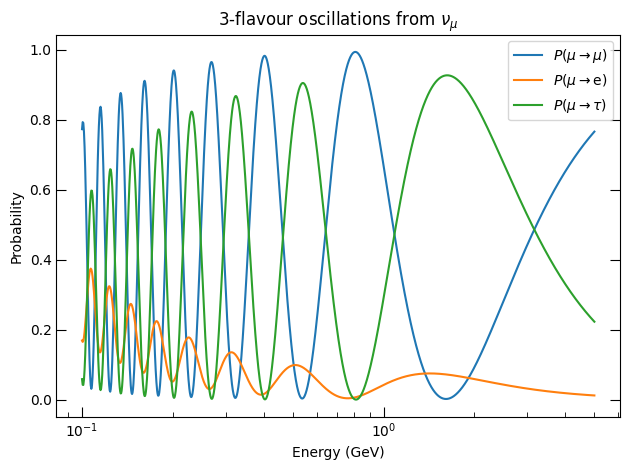

In [8]:
fig, ax = custom_subplots()

ax.plot(bins, mu_survival, label=r'$P(\mu\rightarrow\mu)$')
ax.plot(bins, e_appearance, label=r'$P(\mu\rightarrow\text{e})$')
ax.plot(bins, tau_appearance, label=r'$P(\mu\rightarrow\tau)$')

ax.legend()

ax.set_xscale('log')

ax.set_title(r'3-flavour oscillations from $\nu_\mu$')
ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Probability')

plt.tight_layout();

In [9]:
fluxtools = FluxTools()
lognormflux = LogNormalFlux(shape=0.2, scale=2.2)

pdf = fluxtools.pdfwrap(lognormflux)

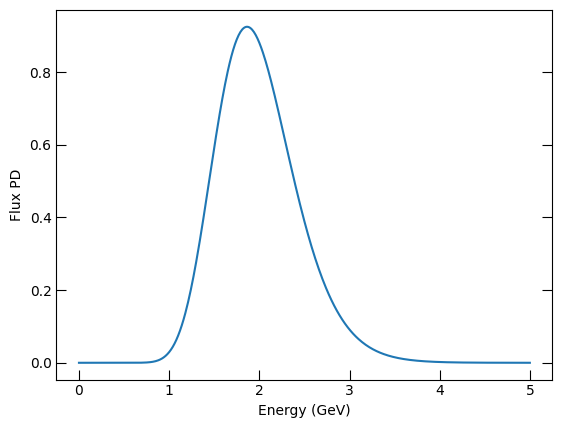

In [10]:
fig, ax = custom_subplots()

bins = np.linspace(0, 5, pdf.shape[0])

ax.plot(bins, pdf)

ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Flux PD');

In [11]:
# Create an experiment
bin_weights = fluxtools.getNuMuAsimov(flux=lognormflux, osccalc=osccalc)
bin_edges = fluxtools.binEdges

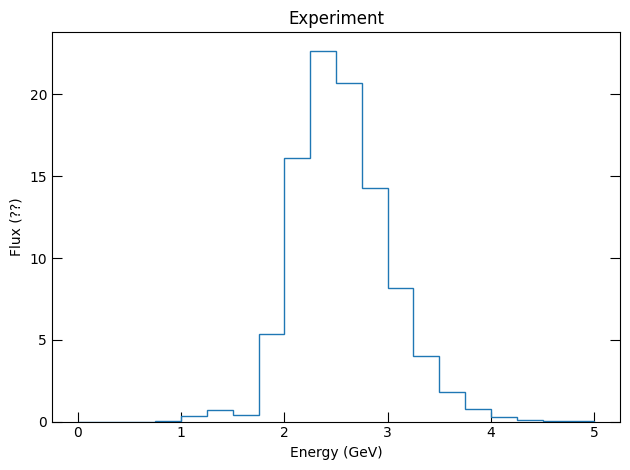

In [12]:
fig, ax = custom_subplots()

ax.hist(bin_edges[:-1], bin_edges, weights=bin_weights, histtype='step')

ax.set_title('Experiment')
ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Flux (??)')

plt.tight_layout();

In [13]:
# Experiments in a bunch of fake universes...
exp_universes = [
    fluxtools.genNuMuExperiment(lognormflux, osccalc) for _ in range(10_000)
]

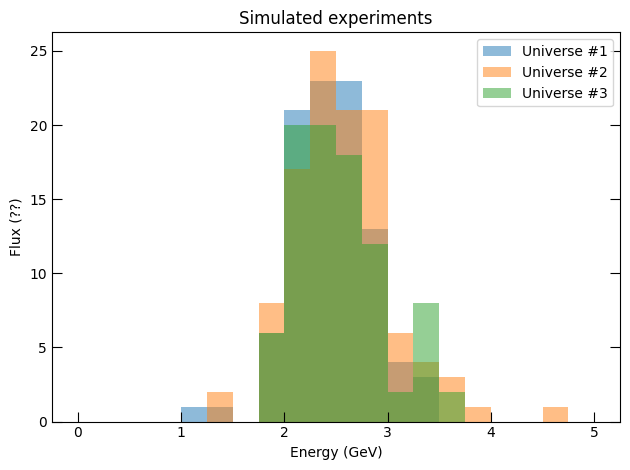

In [14]:
fig, ax = custom_subplots()

for i, exp_universe in enumerate(exp_universes[:3]):
    ax.hist(
        bin_edges[:-1], 
        bin_edges, 
        weights=exp_universe, 
        alpha=0.5,
        label=f'Universe #{i + 1}'
    )

ax.legend()

ax.set_title('Simulated experiments')
ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Flux (??)')

plt.tight_layout();

In [15]:
# Possible osc. parameters in the neutrino oscillation multi-verse (TM)...

d_m32_array = np.linspace(2.2E-3, 2.6E-3, 20)
sin_sq_23_array = np.linspace(0.35, 0.65, 20)
d_cp_array = np.linspace(0, 2 * np.pi, 20)

# d_m32_array = np.linspace(2.0E-3, 2.8E-3, 20)
# sin_sq_23_array = np.linspace(0.25, 0.75, 20)
# d_cp_array = np.linspace(0, 2 * np.pi, 20)

In [16]:
asimov_array = fluxtools.makeNuMuAsimovArray(
    lognormflux, 
    osccalc,
    d_m32_array,
    sin_sq_23_array,
    d_cp_array
)

In [17]:
mu_ll_array_test = [
    [
        [
            FitTools.getPoissonLL(asimov, bin_weights) for asimov in asimov_row
        ] for asimov_row in asimov_mat
    ] for asimov_mat in asimov_array
]

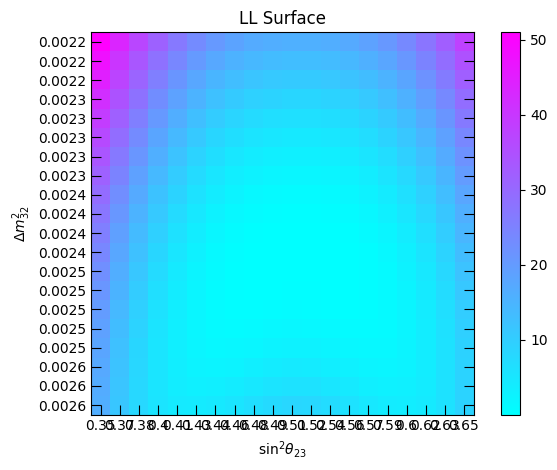

In [18]:
fig, ax = custom_subplots()

image = ax.imshow(FitTools.profile3Dto2D(mu_ll_array_test, [2, 1]), cmap='cool')
colourbar = fig.colorbar(image)

ax.set_xticks(range(sin_sq_23_array.shape[0]))
ax.set_yticks(range(d_m32_array.shape[0]))

ax.set_xticklabels(np.round(sin_sq_23_array, 2))
ax.set_yticklabels(np.round(d_m32_array, 4))

ax.set_title('LL Surface')
ax.set_xlabel(r'$\text{sin}^2 \theta_{23}$')
ax.set_ylabel(r'$\Delta m_{32}^2$')

plt.tight_layout();

## LL (Current cuts)

In [19]:
ds = Datasets()

Datasets found:
- MINI_DATA_DIR
- DATA_V2_DIR
- DATA_V3_DIR
- REALLY_MINI_DIR
- COPYMERGED_C6_DIR
- COPYMERGED_C7_DIR
- COPYMERGED_C8_DIR
- COPYMERGED_C9_DIR
- COPYMERGED_C10_DIR


In [20]:
data = ana.NOvAData.init_from_copymerge_h5(
    h5dirs=[
        ds.COPYMERGED_C8_DIR,  # type: ignore
        ds.COPYMERGED_C9_DIR,  # type: ignore
        ds.COPYMERGED_C10_DIR  # type: ignore
    ]
)

In [21]:
from utils import *

In [23]:
from transforms import *

In [24]:
cuts = ana.Cuts.init_nova_cuts()

In [25]:
full_cut_table = cuts.apply_all_cuts(data.table)

In [45]:
# Stuff calculated by the spectrum class
values_true, edges_true = np.histogram(
    data.table[data.table['rec.mc.nu.E'] > 0]['rec.mc.nu.E'],
    bins=np.linspace(0, 10, 100 + 1)
)
values_exp, edges_exp = np.histogram(
    full_cut_table['rec.energy.numu.lstmnu'],
    bins=np.linspace(0, 10, 100 + 1)
)
cent_true = (edges_true[:-1] + edges_true[1:]) / 2
cent_exp = (edges_exp[:-1] + edges_exp[1:]) / 2

In [46]:
osccalc = OscCalc(
    sinSqTheta12=0.307,
    sinSqTheta13=0.0218,
    sinSqTheta23=0.536,
    deltamSq21=7.53e-5,
    deltamSq32=2.444e-3,
    dcp=1.37 * np.pi,

    density=2.7,
    L=811,
    
    isAntiNu=+1  # Set to neutrino
)

In [47]:
def get_flux(xp, yp):
    class Flux():
        def flux(self, x):
            return np.interp(
                x,
                xp,
                yp,
                left=0,
                right=0
            )
    
    return Flux()

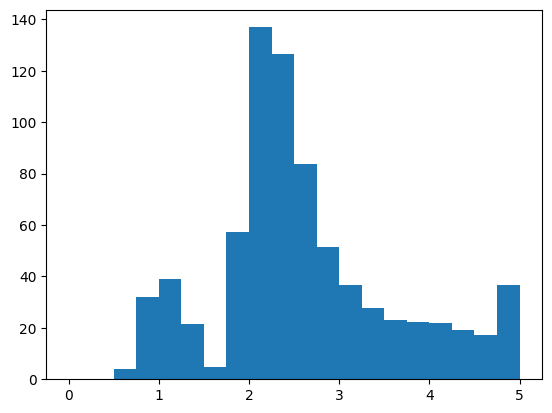

In [55]:
exp_flux = get_flux(
    xp=values_exp,
    yp=cent_exp
)
exp_bin_weights = fluxtools.getNuMuAsimov(
    flux=exp_flux,
    osccalc=osccalc
)
plt.hist(
    fluxtools.binEdges[:-1],
    bins=fluxtools.binEdges,
    weights=exp_bin_weights * np.histogram(
        full_cut_table['rec.energy.numu.lstmnu'],
        bins=fluxtools.binEdges
    )[0]
);

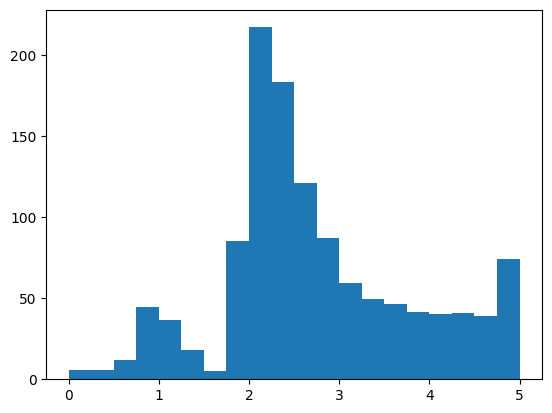

In [57]:
true_flux = get_flux(
    xp=values_true,
    yp=cent_true
)
true_bin_weights = fluxtools.getNuMuAsimov(
    flux=true_flux,
    osccalc=osccalc
)
plt.hist(
    fluxtools.binEdges[:-1],
    bins=fluxtools.binEdges,
    weights=true_bin_weights * np.histogram(
        data.table[data.table['rec.mc.nu.E'] > 0]['rec.mc.nu.E'],
        bins=fluxtools.binEdges
    )[0]
);

In [82]:
fail_cont_table = cuts.apply_all_cuts(data.table, except_=['Containment'])
fail_cont_table = cuts.apply_cut('Containment', fail_cont_table, passed=False)
new_e_table = pd.concat(
    [
        fail_cont_table[fail_cont_table['rec.mc.nu.E'] > 0]['rec.mc.nu.E'],
        full_cut_table['rec.energy.numu.lstmnu']
    ]
)
new_values_exp, new_edges_exp = np.histogram(
    full_cut_table['rec.energy.numu.lstmnu'],
    bins=np.linspace(0, 10, 100 + 1)
)
new_cent_exp = (new_edges_exp[:-1] + new_edges_exp[1:]) / 2

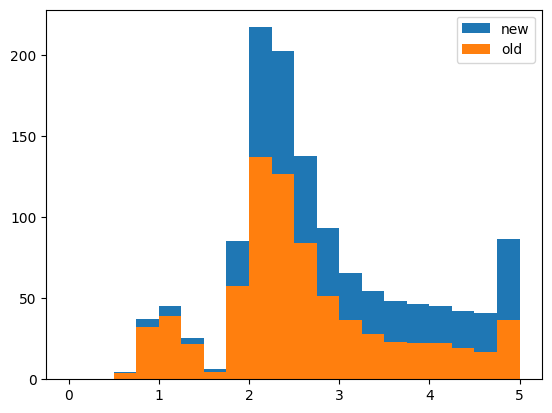

In [86]:
exp_flux_v2 = get_flux(
    xp=new_values_exp,
    yp=new_cent_exp
)
new_exp_bin_weights = fluxtools.getNuMuAsimov(
    flux=exp_flux_v2,
    osccalc=osccalc
)
plt.hist(
    fluxtools.binEdges[:-1],
    bins=fluxtools.binEdges,
    weights=new_exp_bin_weights * np.histogram(
        new_e_table,
        bins=fluxtools.binEdges
    )[0],
    label='new'
)
plt.hist(
    fluxtools.binEdges[:-1],
    bins=fluxtools.binEdges,
    weights=exp_bin_weights * np.histogram(
        full_cut_table['rec.energy.numu.lstmnu'],
        bins=fluxtools.binEdges
    )[0],
    label='old'
)
plt.legend();

In [66]:
d_m32_array = np.linspace(2.2E-3, 2.7E-3, 50)
sin_sq_23_array = np.linspace(0.2, 0.7, 50)
d_cp_array = np.linspace(0, 2 * np.pi, 30)

In [95]:
osccalc_asimov = OscCalc(
    sinSqTheta12=0.307,
    sinSqTheta13=0.0218,
    sinSqTheta23=0.536,
    deltamSq21=7.53e-5,
    deltamSq32=2.444e-3,
    dcp=1.37 * np.pi,

    density=2.7,
    L=811,
    
    isAntiNu=+1  # Set to neutrino
)

In [96]:
asimov_array = fluxtools.makeNuMuAsimovArray(
    true_flux, 
    osccalc_asimov,
    d_m32_array,
    sin_sq_23_array,
    d_cp_array
)

In [102]:
mu_ll_array_v2 = [
    [
        [
            FitTools.getPoissonLL(asimov, exp_bin_weights) for asimov in asimov_row
        ] for asimov_row in asimov_mat
    ] for asimov_mat in asimov_array
]

mu_ll_array_v3 = [
    [
        [
            FitTools.getPoissonLL(asimov, new_exp_bin_weights) for asimov in asimov_row
        ] for asimov_row in asimov_mat
    ] for asimov_mat in asimov_array
]

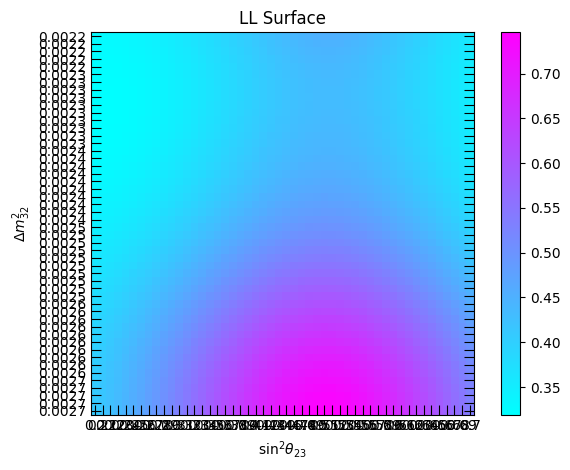

In [103]:
fig, ax = custom_subplots()

image = ax.imshow(FitTools.profile3Dto2D(mu_ll_array_v3, [2, 1]), cmap='cool')
colourbar = fig.colorbar(image)

ax.set_xticks(range(sin_sq_23_array.shape[0]))
ax.set_yticks(range(d_m32_array.shape[0]))

ax.set_xticklabels(np.round(sin_sq_23_array, 2))
ax.set_yticklabels(np.round(d_m32_array, 4))

ax.set_title('LL Surface')
ax.set_xlabel(r'$\text{sin}^2 \theta_{23}$')
ax.set_ylabel(r'$\Delta m_{32}^2$')

plt.tight_layout();

In [104]:
dcpLLArray_v2 = FitTools.profile3Dto1D(mu_ll_array_v2, 0)
sinLLArray_v2 =FitTools.profile3Dto1D(mu_ll_array_v2,1)
dmLLArray_v2 = FitTools.profile3Dto1D(mu_ll_array_v2, 2)

dcpLLArray_v3 = FitTools.profile3Dto1D(mu_ll_array_v3, 0)
sinLLArray_v3 =FitTools.profile3Dto1D(mu_ll_array_v3,1)
dmLLArray_v3 = FitTools.profile3Dto1D(mu_ll_array_v3, 2);

(0, 1, 2)
(1, 2, 0)
(2, 0, 1)
(0, 1, 2)
(1, 2, 0)
(2, 0, 1)


Text(0.5, 0, 'delta m2')

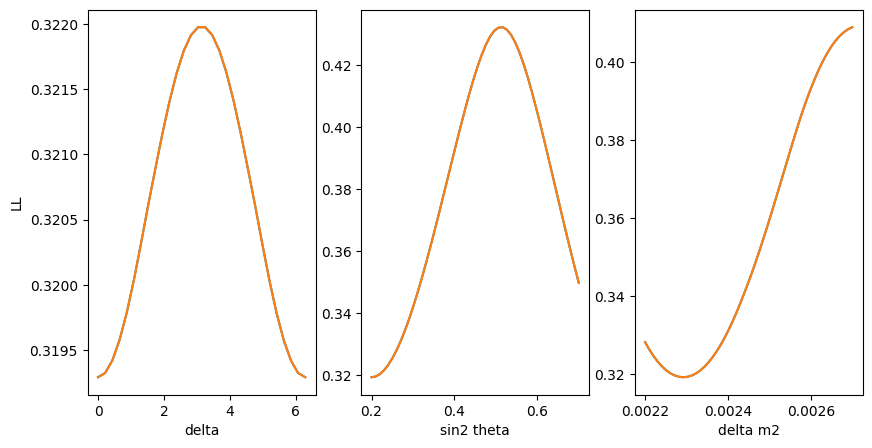

In [105]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].plot(d_cp_array, dcpLLArray_v2, label='truth')
axs[0].plot(d_cp_array, dcpLLArray_v3, label='truth')
axs[0].set_ylabel('LL')
axs[0].set_xlabel('delta')

axs[1].plot(sin_sq_23_array, sinLLArray_v2, label='truth')
axs[1].plot(sin_sq_23_array, sinLLArray_v3, label='truth')
axs[1].set_xlabel('sin2 theta')

axs[2].plot(d_m32_array, dmLLArray_v2, label='truth')
axs[2].plot(d_m32_array, dmLLArray_v3, label='truth')
axs[2].set_xlabel('delta m2')

# axs[2].legend();

In [ ]:
truth_data = data.table[data.table['rec.mc.nu.E'] > 0]['rec.mc.nu.E']
experiment_data = full_cut_table['rec.energy.numu.lstmnu']

In [ ]:
def oscillated_spectrum(energy):
    return (
        1 - np.sin(1.27 * 2.35E-3 * 810 / energy)**2
    )


def lerp(x, x1, x2, y1, y2):
    m = (y2 - y1) / (x2 - x1)
    return y1 + m * (x - x1)


def probcalc_gen(sorted_espec, sorted_ospec):    
    def probcalc(x):
        return np.interp(
            x=x,
            xp=sorted_espec,
            fp=sorted_ospec,
            left=0,
            right=0
        )
    
    return probcalc


def ll_surface(energy):
    # oscilated spectrum
    osc_spectrum_weights = oscillated_spectrum(energy)

    sorted_espec = energy.sort_values()
    sorted_ospec = osc_spectrum_weights[sorted_espec.index].values

    # experiment flux
    probcalc = probcalc_gen(sorted_espec, sorted_ospec)
    flux = fluxtools.getAsimov(lognormflux, probcalc)

    # ll
    mu_ll_array = [
        [
            [
                FitTools.getPoissonLL(asimov, flux) for asimov in asimov_row
            ] for asimov_row in asimov_mat
        ] for asimov_mat in asimov_array
    ]

    return mu_ll_array


In [ ]:
mu_ll_array_exp = ll_surface(experiment_data)

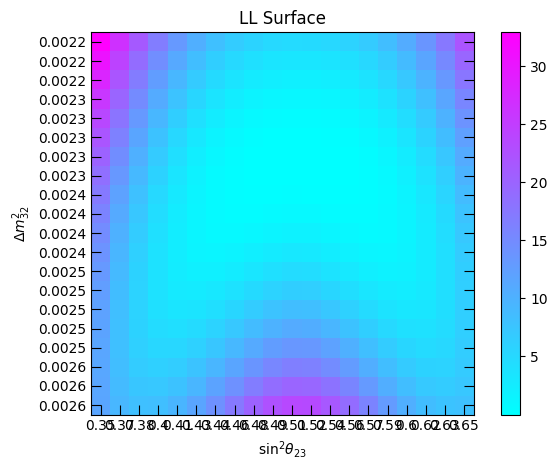

In [ ]:
fig, ax = custom_subplots()

image = ax.imshow(FitTools.profile3Dto2D(mu_ll_array_exp, [2, 1]), cmap='cool')
colourbar = fig.colorbar(image)

ax.set_xticks(range(sin_sq_23_array.shape[0]))
ax.set_yticks(range(d_m32_array.shape[0]))

ax.set_xticklabels(np.round(sin_sq_23_array, 2))
ax.set_yticklabels(np.round(d_m32_array, 4))

ax.set_title('LL Surface')
ax.set_xlabel(r'$\text{sin}^2 \theta_{23}$')
ax.set_ylabel(r'$\Delta m_{32}^2$')

plt.tight_layout();

In [ ]:
dcpLLArray_exp = FitTools.profile3Dto1D(mu_ll_array_exp, 0)
sinLLArray_exp=FitTools.profile3Dto1D(mu_ll_array_exp,1)
dmLLArray_exp = FitTools.profile3Dto1D(mu_ll_array_exp, 2);

(0, 1, 2)
(1, 2, 0)
(2, 0, 1)


In [ ]:
# =================================================================

In [ ]:
mu_ll_array = ll_surface(truth_data)

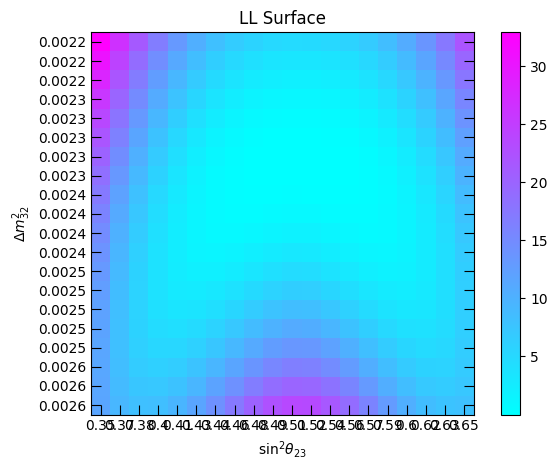

In [ ]:
fig, ax = custom_subplots()

image = ax.imshow(FitTools.profile3Dto2D(mu_ll_array, [2, 1]), cmap='cool')
colourbar = fig.colorbar(image)

ax.set_xticks(range(sin_sq_23_array.shape[0]))
ax.set_yticks(range(d_m32_array.shape[0]))

ax.set_xticklabels(np.round(sin_sq_23_array, 2))
ax.set_yticklabels(np.round(d_m32_array, 4))

ax.set_title('LL Surface')
ax.set_xlabel(r'$\text{sin}^2 \theta_{23}$')
ax.set_ylabel(r'$\Delta m_{32}^2$')

plt.tight_layout();

In [ ]:
dcpLLArray = FitTools.profile3Dto1D(mu_ll_array, 0)
sinLLArray=FitTools.profile3Dto1D(mu_ll_array,1)
dmLLArray = FitTools.profile3Dto1D(mu_ll_array, 2);

(0, 1, 2)
(1, 2, 0)
(2, 0, 1)


In [ ]:
# ===================================================================

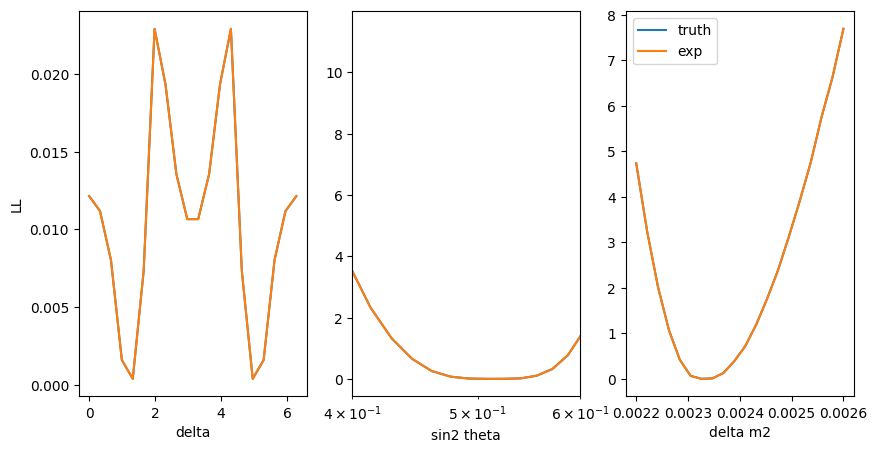

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].plot(d_cp_array, dcpLLArray, label='truth')
axs[0].plot(d_cp_array, dcpLLArray_exp, label='exp')
axs[0].set_ylabel('LL')
axs[0].set_xlabel('delta')

axs[1].plot(sin_sq_23_array, sinLLArray, label='truth')
axs[1].plot(sin_sq_23_array, sinLLArray_exp, label='exp')
axs[1].set_xlabel('sin2 theta')
axs[1].set_xlim(0.4, 0.6)
axs[1].set_xscale('log')

axs[2].plot(d_m32_array, dmLLArray, label='truth')
axs[2].plot(d_m32_array, dmLLArray_exp, label='exp')
axs[2].set_xlabel('delta m2')

axs[2].legend();